In [1]:
%matplotlib inline

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from numpy import linalg
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, silhouette_samples, silhouette_score

---

## [1] DATA

In [2]:
iris = load_iris()
X = iris.data
y = iris.target

In [3]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'],
      dtype='<U10')

In [4]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

---

## [2] Plot Iris in 3D

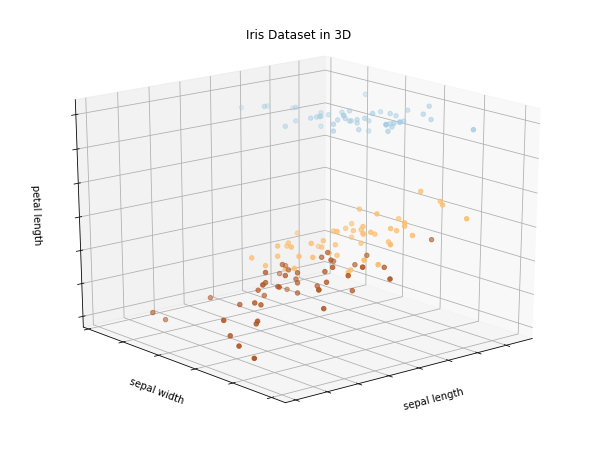

In [5]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-160, azim=130)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.Paired)
ax.set_title("Iris Dataset in 3D")
ax.set_xlabel("sepal length")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("sepal width")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("petal length")
ax.w_zaxis.set_ticklabels([])

plt.show()

---

## [3] K-means

We happen to know there are 3 clusters because we have ground truth labels. However, with true unsupervised learning we don't have labels so finding the "best" number of clusters is context-driven and often challenging.

In [6]:
kmeans = KMeans(n_clusters=3, random_state=42, n_jobs=-1)

In [7]:
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

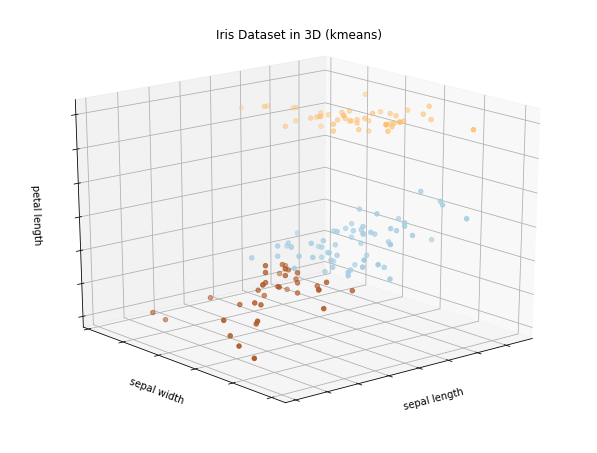

In [8]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-160, azim=130)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=kmeans.labels_, cmap=plt.cm.Paired)
ax.set_title("Iris Dataset in 3D (kmeans)")
ax.set_xlabel("sepal length")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("sepal width")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("petal length")
ax.w_zaxis.set_ticklabels([])

plt.show()

## [4] Are My Clusters Any Good?

In the case where I don't actually have a priori knowledge about the number of clusters, how do I know how many clusters to choose? There are a number of methods to address this challenge. 

### Method 1: Silhouette Plot

From sklearn:

Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

$s_i = \frac{b(i)-a(i)}{max(a_i, b_i)}$

In [10]:
n_clusters = 3
y_lower = 10
cluster_labels = kmeans.fit_predict(X)
silhouette_avg = silhouette_score(X, cluster_labels)
silhouette_values = silhouette_samples(X, cluster_labels)

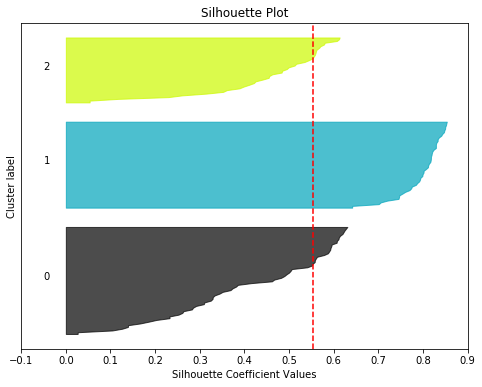

In [11]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i and sort them
        ith_cluster_silhouette_values = silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

ax.set_title("Silhouette Plot")
ax.set_xlabel("Silhouette Coefficient Values")
ax.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_yticks([])  # Clear the yaxis labels / ticks
#ax.set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1]);
ax.set_xticks(np.arange(-0.1, 1, 0.1));

---

Pretend we didn't know how many clusters to choose. How would we approach it? Answer: for loop + avg(silhouette score)!

In [15]:
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_jobs=-1)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(i, silhouette_avg)

2 0.680813620271
3 0.552591944521
4 0.497825690075
5 0.488517550854
6 0.368205696538
7 0.355379055751
8 0.365164535737
9 0.32883150318
10 0.318374986308


In [13]:
type(X)

numpy.ndarray

In [16]:
def optimal_clusterer(X, max_clusters=10):
    '''
    Iterative K-means clustering that finds optimal # of clusters based on silhouette score.
    
    Parameters
    ----------
    X: numpy ndarray
        data to cluster on
    
    max_clusters: int, optional, default: 10 
        max number of clusters to try
    
    Attributes
    ----------
    best number of clusters
    
    silhouette score
    '''
    score = []
    for i in range(2, max_clusters+1):
        kmeans = KMeans(n_clusters=i, random_state=42, n_jobs=-1)
        cluster_labels = kmeans.fit_predict(X)
        score.append(silhouette_score(X, cluster_labels))
    return np.argmax(score)+2, round(max(score), 4)

In [17]:
optimal_clusterer(X)

(2, 0.68079999999999996)